In [459]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

import matplotlib.pyplot as plt

In [460]:
df = pd.read_csv('data/train_data.csv')

In [461]:
key_columns = ['Gender', 'IsActiveMember', 'Exited', 'Geography', 'NumOfProducts', 'Age']
utils_columns = ['Balance', 'Tenure', 'EstimatedSalary', 'CreditScore', 'HasCrCard']

In [462]:
df = df[key_columns + utils_columns]
df.head()

,Gender,IsActiveMember,Exited,Geography,NumOfProducts,Age,Balance,Tenure,EstimatedSalary,CreditScore,HasCrCard
0,Male,1.0,0,France,1,28.0,131694.04,7,161205.61,627,1.0
1,Male,1.0,0,France,2,34.0,0.00,2,181419.29,597,0.0
2,Male,1.0,0,France,2,39.0,0.00,7,100862.54,724,1.0
3,Female,0.0,1,Germany,3,56.0,118577.24,5,61164.45,663,1.0
4,Female,1.0,0,France,2,33.0,0.00,5,103737.82,627,1.0


# Pre-processing

### TrainTest - Nettoyage - Encodage

In [463]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)

In [464]:
trainset['Exited'].value_counts()

Exited
0    90534
1    24329
Name: count, dtype: int64

In [465]:
testset['Exited'].value_counts()

Exited
0    22595
1     6121
Name: count, dtype: int64

### Outliers

In [466]:
def remove_outliers(df):
    list_col_name = ['Age']
    for col in list_col_name:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        outliers_df = df.query(f"{col} < @lower_bound | {col} > @upper_bound")
        df = df.drop(outliers_df.index)

    return df


### Feature Engineering

In [467]:
def feature_engineering(df):
    # df['IsGerman'] = (df['Geography'] == 'Germany').astype(int)

    # df["NumProductsGroup"] = np.where(df["NumOfProducts"] == 1, 1,
    #                      np.where(df["NumOfProducts"] == 2, 2, 3))
    
    # df['HasBalance'] = (df['Balance'] > 0).astype(int)

    # df["AgeGroup"] = pd.cut(
    #     df["Age"],
    #     bins=[0, 30, 35, 40, 45, 50, 55, 60, 100],
    #     labels=[1, 2, 3, 4, 5, 6, 7, 8]
    # ).astype(int)

    # df["AgeOver39"] = (df["Age"] > 39).astype(int)

    bins = [-np.inf, 0, 50000, 100000, 150000, 200000, np.inf]
    labels = ["Nulle", "Faible", "Moyen", "Normal", "Élevé", "Très élevé"]
    df["BalanceCat"] = pd.cut(df["Balance"], bins=bins, labels=labels, right=True, include_lowest=True)
    df["BalanceCat"] = df["BalanceCat"].astype(pd.CategoricalDtype(categories=labels, ordered=True))

    # df["is_young_high_income"] = (df["Age"] < 30) & (df["EstimatedSalary"] > 100000)
    df["ratio_salary_Age"] = (df["EstimatedSalary"] +1e-5) / df["Age"]
    # df["is_active_creditCard"] = (df["HasCrCard"] == 1) & (df["IsActiveMember"] == 1)

    # df["IsBalanceZero"] = (df["Balance"] == 0).astype(int)
    # df["BalanceToSalary"] = df["Balance"] / (df["EstimatedSalary"] + 1e-6)
    # df["IsMultiProd"] = (df["NumOfProducts"] >= 2).astype(int)

        # --- Statuts produits / activité
    # df["Has4Products"]  = (df["NumOfProducts"] == 4).astype(int)           # catégorie rare
    df["Active_x_Multi"]= ((df["IsActiveMember"]==1) & (df["NumOfProducts"]>=2)).astype(int)

    # --- Balance & salaire
    # df["BalancePerProd"]  = df["Balance"] / df["NumOfProducts"].clip(lower=1)
    # df["SalaryPerProd"]   = df["EstimatedSalary"] / df["NumOfProducts"].clip(lower=1)

    # --- Age / Tenure / Credit
    # df["TenurePerAge"]  = df["Tenure"] / (df["Age"] + 1e-6)
    # df["IsSenior"]      = (df["Age"] >= 60).astype(int)
    # df["SeniorInactive"]= ((df["Age"] >= 60) & (df["IsActiveMember"]==0)).astype(int)
    # df["LowCredit"]     = (df["CreditScore"] < 600).astype(int)
    # df["HighCredit"]    = (df["CreditScore"] >= 750).astype(int)
    

    return df

In [468]:
def imputation(df):
    # df = df.drop(columns=["Age", "Balance", "Tenure", "NumOfProducts", "Geography", "HasCrCard", "EstimatedSalary", "CreditScore"])
    df = df.drop(columns=["Age"])
    return df

In [469]:
def preprocessing(df):
    # df = remove_outliers(df)
    df = feature_engineering(df)
    # df = encodage(df)
    # df = imputation(df)
    
    
    X = df.drop('Exited', axis=1)
    y = df['Exited']
    print(y.value_counts())

    return X, y

In [470]:
X_train, y_train = preprocessing(trainset)
X_test, y_test= preprocessing(testset)

Exited
0    90534
1    24329
Name: count, dtype: int64
Exited
0    22595
1     6121
Name: count, dtype: int64


## Modellisation

In [471]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import MEstimateEncoder

from xgboost import XGBClassifier

In [472]:
# l’ordre que tu as défini pour ta variable catégorisée
BALANCE_ORDER = ["Nulle", "Faible", "Moyen", "Normal", "Élevé", "Très élevé"]

In [473]:
column_transformer = ColumnTransformer(
    transformers=[
        # ("encoder", OneHotEncoder(sparse_output=False, drop="first", handle_unknown="ignore"), ["Gender", "Geography"]),
        ("tgt", MEstimateEncoder(m=10), ["Gender", "Geography", "NumOfProducts"]),
        ("encoderO", OrdinalEncoder(categories=[BALANCE_ORDER], handle_unknown="use_encoded_value", unknown_value=-1),["BalanceCat"]),
        # ("poly", PolynomialFeatures(degree=2, include_bias=False), ["Tenure", "EstimatedSalary", "CreditScore", "Age"])
    ],
    remainder="passthrough",                 # garde les autres colonnes telles quelles
    verbose_feature_names_out=False,
    )

In [474]:
preprocessor = make_pipeline(
    column_transformer,
    SelectKBest(k="all"),
)

In [475]:
RandomForest = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("rf", RandomForestClassifier(random_state=0, n_jobs=4))
    ])

DecisionTreeC = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("decisionTreeClassifier", DecisionTreeClassifier(random_state=0))
    ])
AdaBoost = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("AdaBoost", AdaBoostClassifier(random_state=0))
    ])
KNNe = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("scaler", StandardScaler()),
    ("KNNe", KNeighborsClassifier())
    ])
xgb_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("xgb", XGBClassifier(random_state=0, n_jobs=4))
    ])

In [476]:
dict_of_models = {#'RandomForest' : RandomForest, 
                #   'decisionTreeClassifier' : DecisionTreeC,
                  'xgb' : xgb_pipe,
                #   'AdaBoost' : AdaBoost,
                #   'KNN' : KNNe
                  }

## Evaluation

In [477]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [478]:
def evaluation(model):
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)

    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    

    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4, scoring='f1', train_sizes=np.linspace(0.1 ,1, 10))

    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    

In [479]:
def get_feature_importances(pipeline, step_preprocessor, step_model_name):
    step_model_name = pipeline.named_steps[step_model_name]
    feature_names = pipeline.named_steps[step_preprocessor].get_feature_names_out()
    # Récupérer les importances
    importances = step_model_name.feature_importances_
    # Mettre dans un DataFrame et tracer
    pd.DataFrame(importances, index=feature_names, columns=["importance"]).sort_values(by="importance", ascending=False).plot.bar(figsize=(12,5))

xgb
[[21315  1280]
 [ 2726  3395]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     22595
           1       0.73      0.55      0.63      6121

    accuracy                           0.86     28716
   macro avg       0.81      0.75      0.77     28716
weighted avg       0.85      0.86      0.85     28716



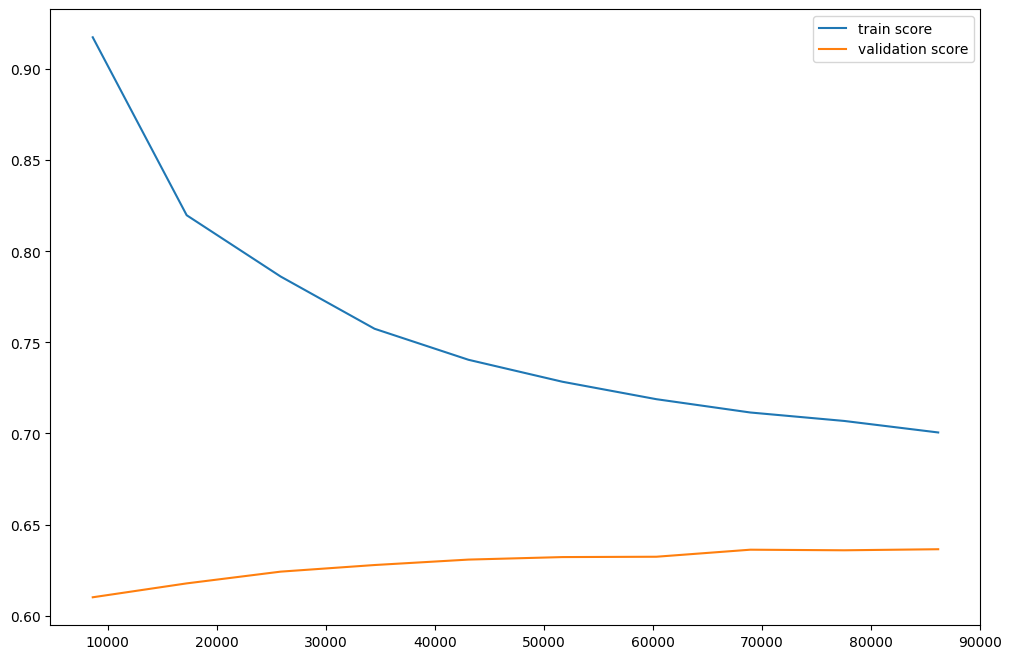

In [480]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)


In [481]:
# get_feature_importances(RandomForest, "preprocessor", "rf")

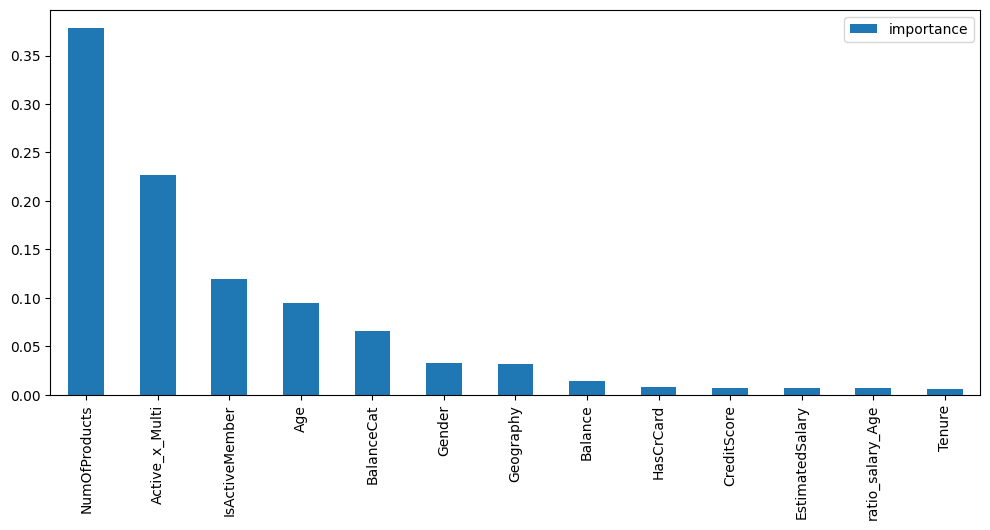

In [482]:
get_feature_importances(xgb_pipe, "preprocessor", "xgb")

## OPTIMISATION


In [483]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [484]:
hyper_params = {'rf__n_estimators' : [500, 1000],
                "rf__max_depth": [None, 8, 12, 16, 20],
                "rf__min_samples_split": [2, 5, 10],
                "rf__min_samples_leaf": [1, 5, 10, 20, 30],
                "rf__max_features": ["sqrt", 0.5, None],
                "rf__class_weight": ["balanced", "balanced_subsample"],
                'preprocessor__selectkbest__k':range(4, 10),
                }

In [485]:
hyper_params_XGB = {
    # Complexité du modèle
    "xgb__subsample": [0.8, 0.9],
    "xgb__reg_lambda": [8, 9, 10],
    "xgb__reg_alpha": [0.5, 0.6],
    "xgb__n_estimators": [1040, 1050],  # gros nombre + early stopping
    "xgb__min_child_weight": [2, 3, 4],
    "xgb__max_depth": [5],
    "xgb__max_delta_step" :[2],
    "xgb__learning_rate": [0.010, 0.015, 0.02],
    "xgb__gamma": [0.9, 1, 1.1, 1.2],
    "xgb__colsample_bytree": [0.8, 0.9, 1.0],
    'preprocessor__selectkbest__k':["all", 6, 10],
    # "preprocessor__columntransformer__poly__degree": [2, 3, 4],
    "preprocessor__columntransformer__tgt__m": [2, 5, 10, 20]
}


In [486]:
grid = RandomizedSearchCV(xgb_pipe, hyper_params_XGB, scoring='f1', cv=5 ,n_jobs=4, n_iter=500) #n_iter=120
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

{'xgb__subsample': 0.8, 'xgb__reg_lambda': 9, 'xgb__reg_alpha': 0.6, 'xgb__n_estimators': 1040, 'xgb__min_child_weight': 2, 'xgb__max_depth': 5, 'xgb__max_delta_step': 2, 'xgb__learning_rate': 0.02, 'xgb__gamma': 1.2, 'xgb__colsample_bytree': 1.0, 'preprocessor__selectkbest__k': 'all', 'preprocessor__columntransformer__tgt__m': 10}
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     22595
           1       0.74      0.55      0.63      6121

    accuracy                           0.86     28716
   macro avg       0.81      0.75      0.77     28716
weighted avg       0.85      0.86      0.85     28716



[[21377  1218]
 [ 2741  3380]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     22595
           1       0.74      0.55      0.63      6121

    accuracy                           0.86     28716
   macro avg       0.81      0.75      0.77     28716
weighted avg       0.85      0.86      0.85     28716



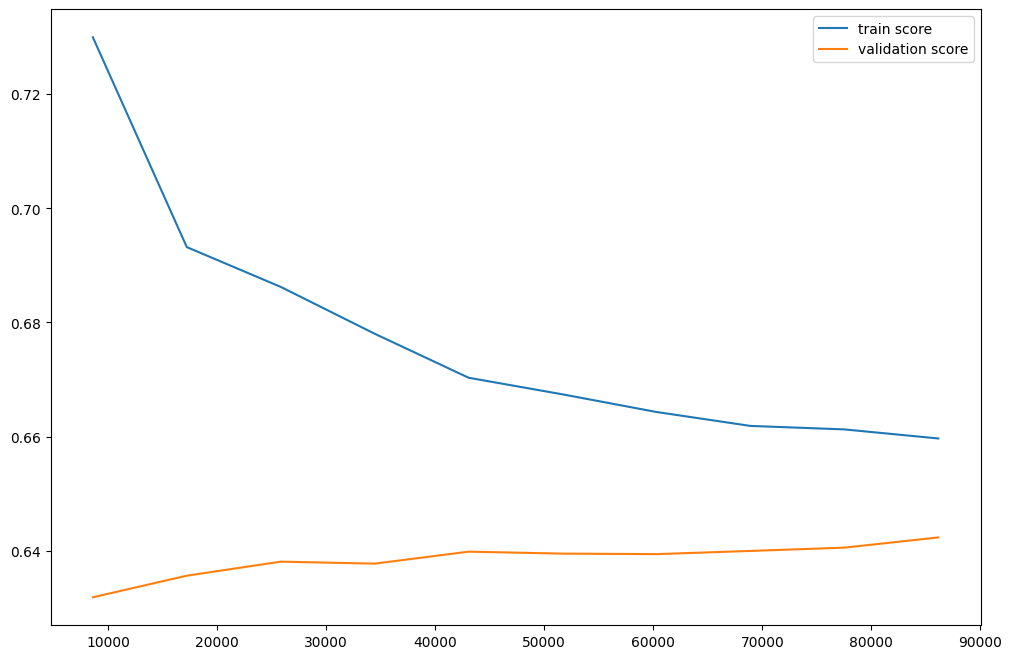

In [487]:
evaluation(grid.best_estimator_)

### Precision Recall Curve

In [488]:
from sklearn.metrics import precision_recall_curve

In [489]:
precision, recall, threshold = precision_recall_curve(y_train, grid.best_estimator_.predict_proba(X_train)[:, 1])

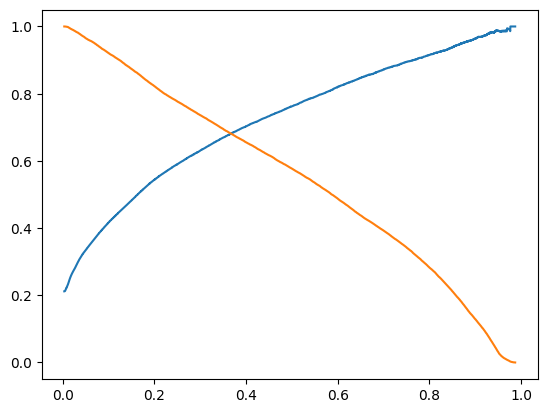

In [490]:
plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend
plt.show()

In [491]:
def best_f1(model):
    best_t, best_f1 = 0, 0
    proba = model.predict_proba(X_train)[:, 1]
    for t in np.linspace(0.2, 0.8, 60):
        preds = (proba > t).astype(int)
        score = f1_score(y_train, preds)
        if score > best_f1:
            best_f1, best_t = score, t

    best_threshold = best_t
    print("Best threshold:", best_t, "F1:", best_f1)
    return best_threshold

In [492]:
best_threshold = best_f1(grid.best_estimator_)


Best threshold: 0.34237288135593225 F1: 0.6819344524380495


In [493]:
def model_final(model, X, threshold=0.5):
    proba = model.predict_proba(X)[:, 1]  # proba classe positive
    return (proba > threshold).astype(int)

In [494]:
best_model = grid.best_estimator_
# best_model.fit(X_train, y_train)
y_pred_test = model_final(best_model, X_test, threshold=best_threshold)

In [495]:
f1_score(y_test, y_pred_test)

0.6600460792881544

### Entraînement sur le dataset complet

In [496]:
df = pd.read_csv('data/train_data.csv')
df = df[key_columns + utils_columns]
X_df, y_df = preprocessing(df)

Exited
0    113129
1     30450
Name: count, dtype: int64


In [497]:
final_model = grid.best_estimator_
final_model.fit(X_df, y_df)   # <--- refit ici

y_pred_df = model_final(final_model, X_df, threshold=best_threshold)

In [498]:
f1_score(y_df, y_pred_df)

0.6783317353787153

## Prediction kaggle

In [499]:
df_kaggle = pd.read_csv('data/test_data.csv')

In [500]:
id_col = "ID"          
test_ids = df_kaggle[id_col].copy()

In [501]:
def preprocessing_kaggle(df):
    df = feature_engineering(df)
    X = df
    return X

In [502]:
X_kaggle = preprocessing_kaggle(df_kaggle)

In [503]:
y_pred_kaggle = model_final(best_model, X_kaggle, threshold=best_threshold)

In [504]:
results = pd.DataFrame(
    {
        id_col: test_ids,
        "Exited": y_pred_kaggle
    }
)

In [505]:
results.to_csv("predictions.csv", index=False)